# Global map of drag coefficient (SAH: 0.1-deg vs. SYNBATH topography)

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib.ticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from dask.distributed import Client
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38943,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39685,Total threads: 2
Dashboard: /proxy/45867/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:41725,


In [3]:
data_m2  = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_2d_global.nc')
data_120 = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_120arcsec_2d_global.nc')
data_240 = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_240arcsec_2d_global.nc')
data_01  = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_01_2d_global.nc')
data_02  = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_02_2d_global.nc')
data_10  = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_1deg_2d_global.nc')

In [4]:
grid_JSL = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_025_JSL/output012/ocean_static.nc')
lon = grid_JSL['geolon']
lat = grid_JSL['geolat']
depth = np.array(grid_JSL['deptho'])
yh, xh = grid_JSL.yh, grid_JSL.xh
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(lon)),
                              'lat': (('yh', 'xh'), np.array(lat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)
fac_dep = xr.where(depth_da.depth_xr > 1000, 1, np.nan)
fac_lat = xr.where((lat < 75) & (lat > -75), 1, np.nan)

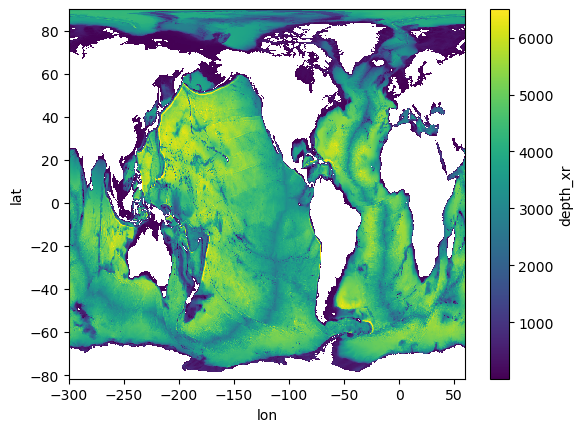

In [5]:
depth_da.depth_xr.plot(x='lon',y='lat')

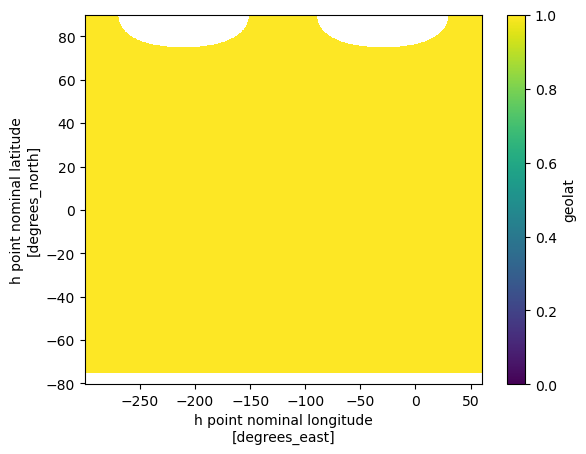

In [6]:
fac_lat.plot(x='xh',y='yh',vmin=0,vmax=1)

In [7]:
fac = np.array(fac_dep) * np.array(fac_lat)
sigma_mag_m2  = np.array(data_m2.sigma_mag) * fac
sigma_mag_120 = np.array(data_120.sigma_mag) * fac
sigma_mag_240 = np.array(data_240.sigma_mag) * fac
sigma_mag_01  = np.array(data_01.sigma_mag) * fac
sigma_mag_02  = np.array(data_02.sigma_mag) * fac
sigma_mag_10  = np.array(data_10.sigma_mag) * fac

In [8]:
sigma_da = xr.Dataset(data_vars={'sigma_m2': (('yh','xh'), sigma_mag_m2),
                                 'sigma_10': (('yh','xh'), sigma_mag_10),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(lon)),
                              'lat': (('yh', 'xh'), np.array(lat))})

## Plot drag coefficient

In [9]:
def plot_global(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

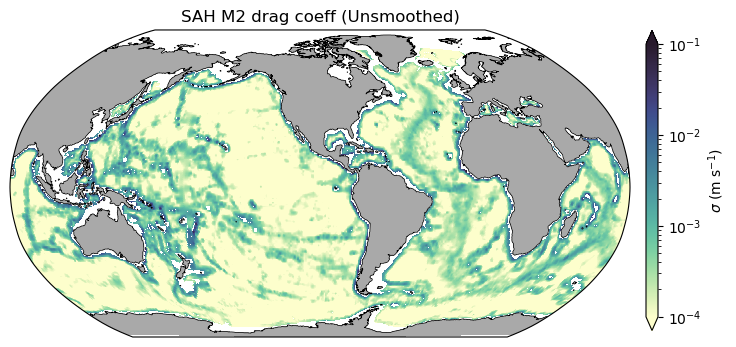

In [10]:
plot_global(lon,lat,sigma_da.sigma_m2,1e-4,1e-1,'SAH M2 drag coeff (Unsmoothed)',cmap=cm.cm.deep)

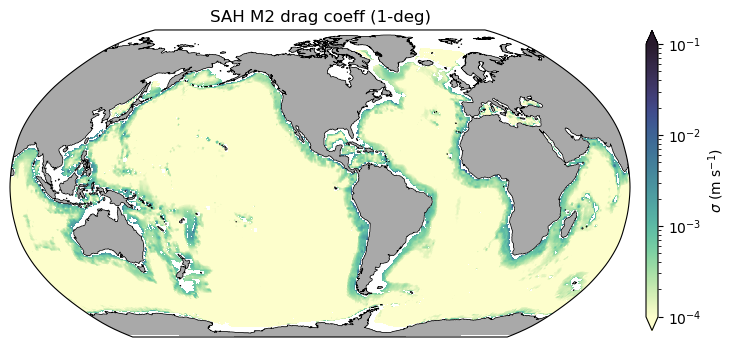

In [11]:
plot_global(lon,lat,sigma_da.sigma_10,1e-4,1e-1,'SAH M2 drag coeff (1-deg)',cmap=cm.cm.deep)

In [12]:
sigma_mag_perc = np.full((5),np.nan)
sigma_mag_perc[0] = np.nanmean(sigma_mag_m2 / sigma_mag_m2)
sigma_mag_perc[1] = np.nanmean(sigma_mag_120/ sigma_mag_m2)
sigma_mag_perc[2] = np.nanmean(sigma_mag_240/ sigma_mag_m2)
sigma_mag_perc[3] = np.nanmean(sigma_mag_01 / sigma_mag_m2)
sigma_mag_perc[4] = np.nanmean(sigma_mag_02 / sigma_mag_m2)

In [13]:
sigma_mag_perc

array([1.        , 0.87344912, 0.70001969, 0.50324112, 0.32312925])

In [14]:
np.nanmean(sigma_da.sigma_m2), np.nanmean(sigma_da.sigma_10)

(0.0005326370147818201, 0.00013209563705060662)

### Why can this ratio be larger than 1? There are places where the ratio is as large as 180! 

In [15]:
ratio = np.array(sigma_da.sigma_10 / sigma_da.sigma_m2)
ratio[ratio>1]=np.nan
print(np.nanmean(ratio))

0.25994888587016873


In [16]:
sigma_xy_m2  = np.abs(data_m2.sigma_xy) * fac
sigma_xy_120 = np.abs(data_120.sigma_xy) * fac
sigma_xy_240 = np.abs(data_240.sigma_xy) * fac
sigma_xy_01  = np.abs(data_01.sigma_xy) * fac
sigma_xy_02  = np.abs(data_02.sigma_xy) * fac
sigma_xy_10  = np.abs(data_10.sigma_xy) * fac

sigma_xy_perc = np.full((5),np.nan)
sigma_xy_perc[0] = np.nanmean(sigma_xy_m2 / sigma_xy_m2)
sigma_xy_perc[1] = np.nanmean(sigma_xy_120/ sigma_xy_m2)
sigma_xy_perc[2] = np.nanmean(sigma_xy_240/ sigma_xy_m2)
sigma_xy_perc[3] = np.nanmean(sigma_xy_01 / sigma_xy_m2)
sigma_xy_perc[4] = np.nanmean(sigma_xy_02 / sigma_xy_m2)

In [17]:
sigma_xy_perc

array([1.        , 3.69915681, 3.69612982, 7.29949455, 7.60050333])

In [18]:
print(np.nanmean(sigma_xy_10 / sigma_xy_m2))

19.669338822069157


In [19]:
sigma_ani_perc = np.full((5),np.nan)
sigma_ani_perc[0] = np.nanmean(sigma_xy_m2 / sigma_mag_m2)
sigma_ani_perc[1] = np.nanmean(sigma_xy_120/ sigma_mag_120)
sigma_ani_perc[2] = np.nanmean(sigma_xy_240/ sigma_mag_240)
sigma_ani_perc[3] = np.nanmean(sigma_xy_01 / sigma_mag_01)
sigma_ani_perc[4] = np.nanmean(sigma_xy_02 / sigma_mag_02)

In [20]:
sigma_ani_perc

array([0.04495285, 0.00554328, 0.00648985, 0.05034819, 0.0452967 ])

## Plot sensitivity: drag coeff vs resolution (smoothed topography)

Text(0.5, 1.0, 'Sensitivity of drag coefficient magnitude to resolution of topography')

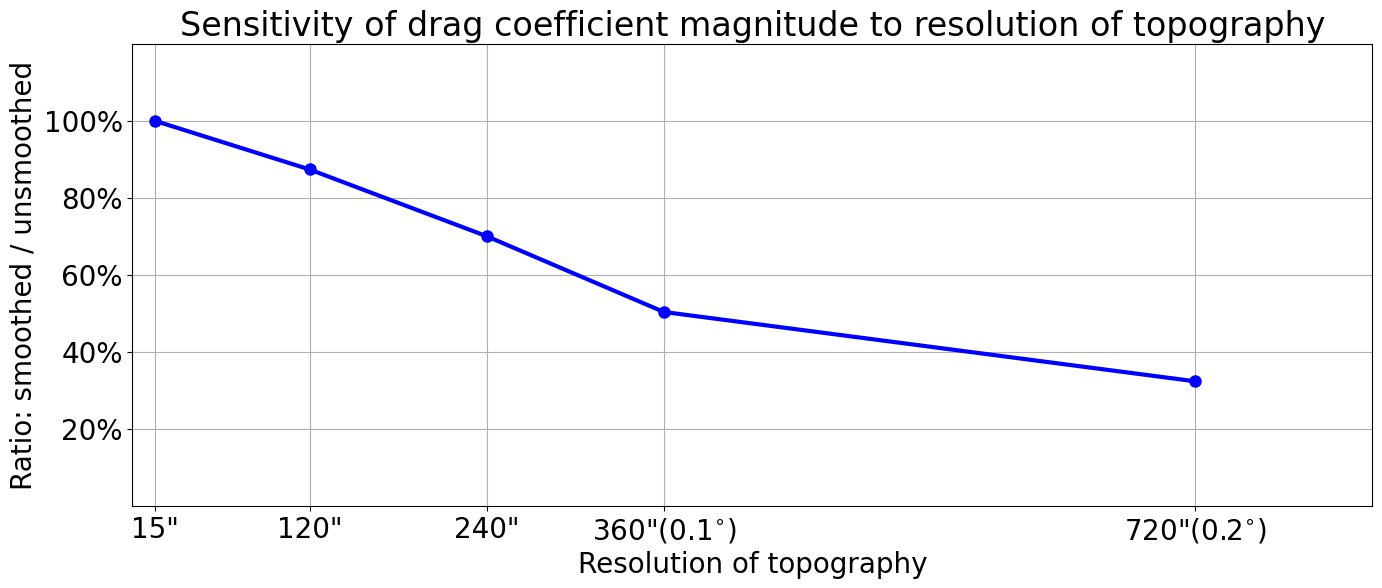

In [21]:
fig = plt.figure(figsize=(16, 6))
# hres = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
hres = np.array([15,120,240,360,720]) # arcsec
plt.plot(hres,sigma_mag_perc,'b-',linewidth=3)
plt.plot(hres,sigma_mag_perc,'bo',markersize=8)
plt.tick_params(labelsize=20)
plt.xlim(0,840)
plt.ylim(0,1.2)
xlabels=['15\"','120\"','240\"','360\"(0.1$^{\circ}$)','720\"(0.2$^{\circ}$)']
ylabels=['20%','40%','60%','80%','100%']
plt.xticks(hres,xlabels)
plt.yticks(np.arange(0.2,1.2,0.2),ylabels)
plt.xlabel('Resolution of topography',fontsize=20)
plt.ylabel('Ratio: smoothed / unsmoothed',fontsize=20)
plt.grid(True)
plt.title('Sensitivity of drag coefficient magnitude to resolution of topography',fontsize=24)
# plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_M2_sensitivity_topog_mag_025_perc.png', dpi=300, bbox_inches='tight')  

Text(0.5, 1.0, 'Sensitivity of cross term to resolution of topography')

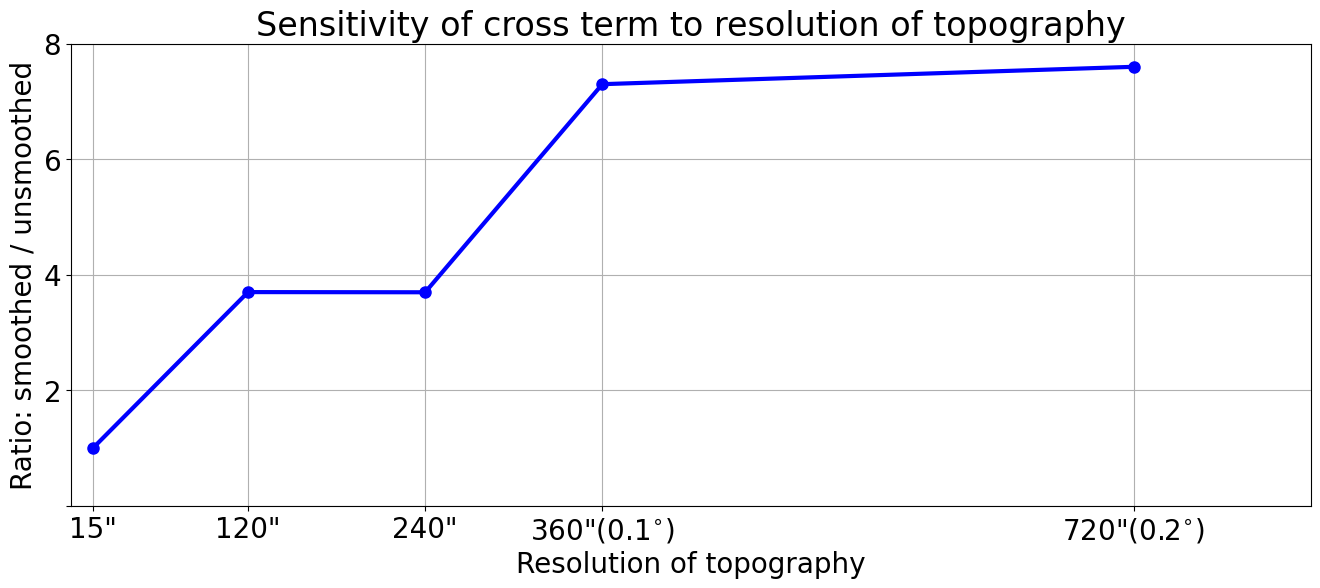

In [22]:
fig = plt.figure(figsize=(16, 6))
# hres = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
# hres = np.array([0,15,60,120,240,360,480,600,720]) # arcsec
hres = np.array([15,120,240,360,720]) # arcsec
plt.plot(hres,sigma_xy_perc,'b-',linewidth=3)
plt.plot(hres,sigma_xy_perc,'bo',markersize=8)
plt.tick_params(labelsize=20)
plt.xlim(0,840)
plt.ylim(0,8)
xlabels=['15\"','120\"','240\"','360\"(0.1$^{\circ}$)','720\"(0.2$^{\circ}$)']
ylabels=['','2','4','6','8']
plt.xticks(hres,xlabels)
plt.yticks(np.arange(0,10,2),ylabels)
plt.xlabel('Resolution of topography',fontsize=20)
plt.ylabel('Ratio: smoothed / unsmoothed',fontsize=20)
plt.grid(True)
plt.title('Sensitivity of cross term to resolution of topography',fontsize=24)
# plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_M2_sensitivity_topog_cross_025_perc.png', dpi=300, bbox_inches='tight')  